In [4]:
import sys
import os
sys.path.append('..')
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'
import argparse
from utils import *

import jax
import equinox as eqx
import jax.numpy as jnp
from jax import random
import optax 
from optax.contrib import reduce_on_plateau
from jax import vmap
import jax_dataloader as jdl
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
jax.config.update("jax_enable_x64", True)

from networks import *
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard

#PATH = "/cluster/work/eirikaf/"
PATH = r"C:\Users\eirik\orbax"
#PATH = None

# LOAD DATA
#data = jnp.load("/cluster/home/eirikaf/phlearn-summer24/eirik_prosjektoppgave/data/advection.npz")
data = jnp.load(r"C:\Users\eirik\OneDrive - NTNU\5. klasse\prosjektoppgave\eirik_prosjektoppgave\data\advection.npz")
x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

# SET PARAMETERS
P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1
NUMBER_OF_SENSORS = M+1

# NORMALIZE DATA
u_normalizer = UnitGaussianNormalizer(u_train)
a_normalizer = UnitGaussianNormalizer(a_train)
x_normalizer = UnitGaussianNormalizer(x)
t_normalizer = UnitGaussianNormalizer(t)

u_train_n = u_normalizer.encode(u_train)
a_train_n = a_normalizer.encode(a_train)

u_val_n = u_normalizer.encode(u_val)
a_val_n = a_normalizer.encode(a_val)

x_n = x_normalizer.encode(x)
t_n = t_normalizer.encode(t)

# Set x and t as class attributes, since they are constant throughout the training
Trainer.x = x_n
Trainer.t = t_n

def compute_loss(model, a, u, key, num_query_points=100):
    """Computes the loss of the model.
    Returns the l2 loss, averaged over the batch. The loss is computed by randomly selecting query points from the input data and evaluating the model at those points.

    Args:
        model (eqx.Module): The model to evaluate.
        a (batch, number_of_sensors): The input data.
        u (batch, num_query_points): The ground truth data at the query points.

    Returns:
        loss (scalar): The loss of the model for the given batch.
    """
    batch_size, Np1, Mp1 = u.shape
            
    # Select random query indices
    t_key, x_key = random.split(key, 2)
    t_idx = random.randint(t_key, (batch_size, num_query_points), 0, Np1)
    x_idx = random.randint(x_key, (batch_size, num_query_points), 0, Mp1)

    # Select the ground truth data at the query points
    # Has shape (batch_size, num_query_points)
    u_at_query_points = u[jnp.arange(batch_size)[:, None], t_idx, x_idx]
    
    # For each input function, compute the prediction of the model at the query points. (inner vmap)
    # Do this for each sample in the batch. (outer vmap)
    # Has shape (batch_size, num_query_points)
    u_pred = vmap(vmap(model, (None, 0, 0)))(a, Trainer.x[x_idx], Trainer.t[t_idx])
    
    #mse loss
    if model.self_adaptive:
        print("self adaptive")
        loss = jnp.mean(model.self_adaptive(t_idx, x_idx) * jnp.square((u_pred - u_at_query_points))) #MSE
    else:
        loss = jnp.mean(jnp.square(u_pred - u_at_query_points))

    return loss

Trainer.compute_loss = staticmethod(compute_loss)

@eqx.filter_jit(donate="all")
def make_step(model, opt_state, a, u, key):
    """Performs a single optimization step."""
    model, opt_state = eqx.filter_shard((model, opt_state), Trainer.replicated)
    a, u = eqx.filter_shard((a,u), (Trainer.sharding_a, Trainer.sharding_u))
    
    loss, grads = eqx.filter_value_and_grad(Trainer.compute_loss)(model, a, u, key)
    updates, opt_state = Trainer.opt.update([grads], opt_state, value=loss)
    model = eqx.apply_updates(model, updates[0])
    
    if model.self_adaptive:
        # normalize λ
        model = eqx.tree_at(lambda m : m.self_adaptive.λ, model, model.self_adaptive.λ/jnp.mean(model.self_adaptive.λ))        
    
    model, opt_state = eqx.filter_shard((model, opt_state), Trainer.replicated)
    
    return model, opt_state, loss

Trainer.make_step = staticmethod(make_step)

@eqx.filter_jit(donate="all-except-first")
def evaluate(model, a, u, key):
    model = eqx.filter_shard(model, Trainer.replicated)
    a, u = eqx.filter_shard((a,u), (Trainer.sharding_a, Trainer.sharding_u))
    return compute_loss(model, a, u, key)

Trainer.evaluate = staticmethod(evaluate)

# Create mesh for sharding (autoparallelism)
num_devices = len(jax.devices())
print(f"Devices: {jax.devices()}")
devices = mesh_utils.create_device_mesh((num_devices, 1))
sharding_u = jshard.PositionalSharding(devices).reshape(num_devices, 1, 1)
sharding_a = jshard.PositionalSharding(devices)
sharding = {"a": sharding_a, "u": sharding_u}
replicated = sharding_a.replicate()

# Set sharding and replicated as class attributes, since they are constant throughout the training
Trainer.sharding_a = sharding_a
Trainer.sharding_u = sharding_u
Trainer.replicated = replicated

# Define hyperparameters
hparams = modified_deeponet.Hparams(number_of_sensors=NUMBER_OF_SENSORS,
                                    period=(x_n[-1]-x_n[0]).item(),
                                    width=100,
                                    depth=7,
                                    learning_rate=1e-3,
                                    interact_size=15,
                                    λ_learning_rate=1e-3,
                                    λ_mask="soft_relu",
                                    λ_shape=(N+1, M+1))

# Define model
model = ModifiedDeepONet(hparams)
model = eqx.filter_shard(model, replicated)

# Dataloaders
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)

# OPTIMIZER 
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:
LEARNING_RATE = 1e-3

θ_learning_rate = 1e-3
λ_learning_rate = 1e-2

θ_optimizer = optax.chain(
    optax.adam(θ_learning_rate),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)

λ_optimizer = optax.chain(optax.adam(λ_learning_rate), optax.scale(-1.))

opt = optax.multi_transform({'θ': θ_optimizer, 'λ': λ_optimizer}, param_labels=param_labels)
opt_state = opt.init(eqx.filter([model], eqx.is_array))


trainer = Trainer(model, opt, opt_state, train_loader, val_loader, hparams = hparams, animate=True, max_epochs=30, save_path=PATH)
trainer(50)

Output()

Devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


self adaptive

self adaptive

In [1]:
import sys
import os
sys.path.append('..')
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'
import argparse
from utils import *

import jax
import equinox as eqx
import jax.numpy as jnp
from jax import random
import optax 
from optax.contrib import reduce_on_plateau
from jax import vmap
import jax_dataloader as jdl
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
jax.config.update("jax_enable_x64", True)

from networks import *
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard

#PATH = "/cluster/work/eirikaf/"
PATH = r"C:\Users\eirik\orbax"
#PATH = None

# LOAD DATA
#data = jnp.load("/cluster/home/eirikaf/phlearn-summer24/eirik_prosjektoppgave/data/advection.npz")
data = jnp.load(r"C:\Users\eirik\OneDrive - NTNU\5. klasse\prosjektoppgave\eirik_prosjektoppgave\data\advection.npz")
x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

# SET PARAMETERS
P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1

# NORMALIZE DATA
u_normalizer = UnitGaussianNormalizer(u_train)
a_normalizer = UnitGaussianNormalizer(a_train)
x_normalizer = UnitGaussianNormalizer(x)
t_normalizer = UnitGaussianNormalizer(t)

u_train_n = u_normalizer.encode(u_train)
a_train_n = a_normalizer.encode(a_train)

u_val_n = u_normalizer.encode(u_val)
a_val_n = a_normalizer.encode(a_val)

x_n = x_normalizer.encode(x)
t_n = t_normalizer.encode(t)

# Set x and t as class attributes, since they are constant throughout the training
Trainer.x = x_n
Trainer.t = t_n

def compute_loss(model, a, u, key, num_query_points=100):
    """Computes the loss of the model.
    Returns the l2 loss, averaged over the batch. The loss is computed by randomly selecting query points from the input data and evaluating the model at those points.

    Args:
        model (eqx.Module): The model to evaluate.
        a (batch, number_of_sensors): The input data.
        u (batch, num_query_points): The ground truth data at the query points.

    Returns:
        loss (scalar): The loss of the model for the given batch.
    """
    batch_size, Np1, Mp1 = u.shape
            
    # Select random query indices
    t_key, x_key = random.split(key, 2)
    t_idx = random.randint(t_key, (batch_size, num_query_points), 0, Np1)
    x_idx = random.randint(x_key, (batch_size, num_query_points), 0, Mp1)

    # Select the ground truth data at the query points
    # Has shape (batch_size, num_query_points)
    u_at_query_points = u[jnp.arange(batch_size)[:, None], t_idx, x_idx]
    
    # For each input function, compute the prediction of the model at the query points. (inner vmap)
    # Do this for each sample in the batch. (outer vmap)
    # Has shape (batch_size, num_query_points)
    u_pred = vmap(vmap(model, (None, 0, 0)))(a, Trainer.x[x_idx], Trainer.t[t_idx])
    
    #mse loss
    if model.self_adaptive:
        loss = jnp.mean(model.self_adaptive(t_idx, x_idx) * jnp.square((u_pred - u_at_query_points))) #MSE
    else:
        loss = jnp.mean(jnp.square(u_pred - u_at_query_points))

    return loss

Trainer.compute_loss = staticmethod(compute_loss)

@eqx.filter_jit(donate="all")
def make_step(model, opt_state, a, u, key):
    """Performs a single optimization step."""
    model, opt_state = eqx.filter_shard((model, opt_state), Trainer.replicated)
    a, u = eqx.filter_shard((a,u), (Trainer.sharding_a, Trainer.sharding_u))
    
    loss, grads = eqx.filter_value_and_grad(Trainer.compute_loss)(model, a, u, key)
    updates, opt_state = Trainer.opt.update([grads], opt_state, value=loss)
    model = eqx.apply_updates(model, updates[0])
    
    if model.self_adaptive:
        # normalize λ
        model = eqx.tree_at(lambda m : m.self_adaptive.λ, model, model.self_adaptive.λ/jnp.mean(model.self_adaptive.λ))        
    
    model, opt_state = eqx.filter_shard((model, opt_state), Trainer.replicated)
    
    return model, opt_state, loss

Trainer.make_step = staticmethod(make_step)

@eqx.filter_jit(donate="all-except-first")
def evaluate(model, a, u, key):
    model = eqx.filter_shard(model, Trainer.replicated)
    a, u = eqx.filter_shard((a,u), (Trainer.sharding_a, Trainer.sharding_u))
    return compute_loss(model, a, u, key)

Trainer.evaluate = staticmethod(evaluate)

# Create mesh for sharding (autoparallelism)
num_devices = len(jax.devices())
devices = mesh_utils.create_device_mesh((num_devices, 1))
sharding_u = jshard.PositionalSharding(devices).reshape(num_devices, 1, 1)
sharding_a = jshard.PositionalSharding(devices)
sharding = {"a": sharding_a, "u": sharding_u}
replicated = sharding_a.replicate()

# Set sharding and replicated as class attributes, since they are constant throughout the training
Trainer.sharding_a = sharding_a
Trainer.sharding_u = sharding_u
Trainer.replicated = replicated

# Dataloaders
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)

num_trials = 10

study = optuna.create_study(
    study_name='test12345',
    storage=f"sqlite:///optuna/optuna.db",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
    sampler = optuna.samplers.TPESampler(seed=2),
    load_if_exists=True,
)

with ProgressBar(mode = "trial") as p:
    p.pbar.update(p.trials_id, total = num_trials)
    study.optimize(modified_deeponet.HparamTuning(train_loader, 
                                                  val_loader, 
                                                  NUMBER_OF_SENSORS, 
                                                  (x_n[-1]-x_n[0]).item(),
                                                  (N+1, M+1),
                                                  max_epochs=30), 
                    n_trials=num_trials, callbacks = [lambda study, trial: p.pbar.advance(p.trials_id)])

Output()

[W 2024-11-23 20:59:34,290] Trial 3 failed with parameters: {'width': 112, 'depth': 7, 'interact_size': 7, 'θ_learning_rate': 0.00518442340053089, 'λ_learning_rate': 0.0019259546699044615} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\eirik\anaconda3\envs\prosjektoppgave\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "c:\Users\eirik\OneDrive - NTNU\5. klasse\prosjektoppgave\eirik_prosjektoppgave\test_problems\..\networks\modified_deeponet.py", line 132, in __call__
    trainer()
  File "c:\Users\eirik\OneDrive - NTNU\5. klasse\prosjektoppgave\eirik_prosjektoppgave\test_problems\..\utils\trainer.py", line 170, in __call__
    self._train_epoch(epoch_idx, train_key)
  File "c:\Users\eirik\OneDrive - NTNU\5. klasse\prosjektoppgave\eirik_prosjektoppgave\test_problems\..\utils\trainer.py", line 204, in _train_epoch
    model, opt_state,

KeyboardInterrupt: 

In [1]:
import sys
import os
sys.path.append("")
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
import equinox as eqx
import jax.numpy as jnp
from jax import random
import optax 
from jax import vmap
import jax_dataloader as jdl
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
jax.config.update("jax_enable_x64", True)

from networks import *
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard

#PATH = "/cluster/work/eirikaf/"
PATH = r"C:\Users\eirik\orbax"
#PATH = None

# LOAD DATA
#data = jnp.load("/cluster/home/eirikaf/phlearn-summer24/eirik_prosjektoppgave/data/advection.npz")
data = jnp.load(r"C:\Users\eirik\OneDrive - NTNU\5. klasse\prosjektoppgave\eirik_prosjektoppgave\data\advection.npz")
x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

# SET PARAMETERS
P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1

# Pre-repeat data 
a_train = jnp.repeat(a_train[:, None, :], N+1, axis=1)
a_val = jnp.repeat(a_val[:, None, :], N+1, axis=1)
a_test = jnp.repeat(a_test[:, None, :], N+1, axis=1)

ModuleNotFoundError: No module named 'networks'

In [11]:
x = jnp.repeat(x[None, :], N+1, axis=0)

In [16]:
t = jnp.repeat(t[:, None], M+1, axis=1)

In [ ]:
import sys
import os
sys.path.append('..')
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
import equinox as eqx
import jax.numpy as jnp
from jax import random
import optax 
from optax.contrib import reduce_on_plateau
from jax import vmap
import jax_dataloader as jdl
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
jax.config.update("jax_enable_x64", True)

from networks import *
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard

#PATH = "/cluster/work/eirikaf/"
PATH = r"C:\Users\eirik\orbax"
#PATH = None

# LOAD DATA
#data = jnp.load("/cluster/home/eirikaf/phlearn-summer24/eirik_prosjektoppgave/data/advection.npz")
data = jnp.load(r"C:\Users\eirik\OneDrive - NTNU\5. klasse\prosjektoppgave\eirik_prosjektoppgave\data\advection.npz")
x = jnp.array(data['x'])
t = jnp.array(data['t'])
a_train = jnp.array(data['a_train'])
u_train = jnp.array(data['u_train'])
a_val = jnp.array(data['a_val'])
u_val = jnp.array(data['u_val'])
a_test = jnp.array(data['a_test'])
u_test = jnp.array(data['u_test'])

# SET PARAMETERS
P = x[-1]
T = t[-1]
M = len(x) - 1
N = len(t) - 1
NUMBER_OF_SENSORS = M + 1
N = len(t)-1

# NORMALIZE DATA
u_normalizer = UnitGaussianNormalizer(u_train)
a_normalizer = UnitGaussianNormalizer(a_train)
x_normalizer = UnitGaussianNormalizer(x)
t_normalizer = UnitGaussianNormalizer(t)

u_train_n = u_normalizer.encode(u_train)
a_train_n = a_normalizer.encode(a_train)

u_val_n = u_normalizer.encode(u_val)
a_val_n = a_normalizer.encode(a_val)

u_test_n = u_normalizer.encode(u_test)
a_test_n = a_normalizer.encode(a_test)

x_n = x_normalizer.encode(x)
t_n = t_normalizer.encode(t)

# Pre-repeat data 
a_train_n = jnp.repeat(a_train_n[:, None, :], N+1, axis=1)
a_val_n = jnp.repeat(a_val_n[:, None, :], N+1, axis=1)
a_test_n = jnp.repeat(a_test_n[:, None, :], N+1, axis=1)

x_n = jnp.repeat(x_n[None, :], N+1, axis=0)
t_n = jnp.repeat(t_n[:, None], M+1, axis=1)

# Set x and t as class attributes, since they are constant throughout the training
Trainer.x = x_n
Trainer.t = t_n

def compute_loss(model, a, u, key, num_query_points=100):
    """Computes the loss of the model.
    Returns the l2 loss, averaged over the batch. The loss is computed by randomly selecting query points from the input data and evaluating the model at those points.

    Args:
        model (eqx.Module): The model to evaluate.
        a (batch, number_of_sensors): The input data.
        u (batch, num_query_points): The ground truth data at the query points.

    Returns:
        loss (scalar): The loss of the model for the given batch.
    """
    batch_size, Np1, Mp1 = u.shape
    
    a, x, t = a[:,::4,::4], Trainer.x[::4,::4], Trainer.t[::4,::4]
    u = u[:,::4,::4]

    u_pred = vmap(model, (0, None, None))(a, x, t)
    
    #mse loss
    if model.self_adaptive:
        loss = jnp.mean(model.self_adaptive() * jnp.square((u_pred - u))) #MSE
    else:
        loss = jnp.mean(jnp.square(u_pred - u))

    return loss

Trainer.compute_loss = staticmethod(compute_loss)

@eqx.filter_jit(donate="all")
def make_step(model, opt_state, a, u, key):
    """Performs a single optimization step."""
    model, opt_state = eqx.filter_shard((model, opt_state), Trainer.replicated)
    a, u = eqx.filter_shard((a,u), (Trainer.sharding_a, Trainer.sharding_u))
    
    loss, grads = eqx.filter_value_and_grad(Trainer.compute_loss)(model, a, u, key)
    updates, opt_state = Trainer.opt.update([grads], opt_state, value=loss)
    model = eqx.apply_updates(model, updates[0])
    
    if model.self_adaptive:
        # normalize λ
        model = eqx.tree_at(lambda m : m.self_adaptive.λ, model, model.self_adaptive.λ/jnp.mean(model.self_adaptive.λ))        
    
    model, opt_state = eqx.filter_shard((model, opt_state), Trainer.replicated)
    
    return model, opt_state, loss

Trainer.make_step = staticmethod(make_step)

@eqx.filter_jit(donate="all-except-first")
def evaluate(model, a, u, key):
    model = eqx.filter_shard(model, Trainer.replicated)
    a, u = eqx.filter_shard((a,u), (Trainer.sharding_a, Trainer.sharding_u))
    return compute_loss(model, a, u, key)

Trainer.evaluate = staticmethod(evaluate)

# Create mesh for sharding (autoparallelism)
num_devices = len(jax.devices())
devices = mesh_utils.create_device_mesh((num_devices, 1, 1))
sharding = jshard.PositionalSharding(devices)
replicated = sharding.replicate()

# Set sharding and replicated as class attributes, since they are constant throughout the training
Trainer.sharding_a = sharding
Trainer.sharding_u = sharding
Trainer.replicated = replicated

# Dataloaders
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)

# Define hyperparameters
hparams = fno2d.Hparams(n_blocks=4,
                        hidden_dim=100,
                        modes_max=10,)

# Define model
model = FNO2d(hparams)
model = eqx.filter_shard(model, replicated)

# Dataloaders
train_loader = jdl.DataLoader(jdl.ArrayDataset(a_train_n, u_train_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)
val_loader = jdl.DataLoader(jdl.ArrayDataset(a_val_n, u_val_n), batch_size=16, shuffle=True, backend='jax', drop_last=True)

# OPTIMIZER 
PATIENCE = 5 # Number of epochs with no improvement after which learning rate will be reduced
COOLDOWN = 0 # Number of epochs to wait before resuming normal operation after the learning rate reduction
FACTOR = 0.5  # Factor by which to reduce the learning rate:
RTOL = 1e-4  # Relative tolerance for measuring the new optimum:
ACCUMULATION_SIZE = 200 # Number of iterations to accumulate an average value:
LEARNING_RATE = 1e-3

θ_learning_rate = 1e-3

opt = optax.chain(
    optax.adam(θ_learning_rate),
    reduce_on_plateau(
        patience=PATIENCE,
        cooldown=COOLDOWN,
        factor=FACTOR,
        rtol=RTOL,
        accumulation_size=ACCUMULATION_SIZE,
    ),
)

opt_state = opt.init(eqx.filter([model], eqx.is_array))

trainer = Trainer(model, 
                  opt, 
                  opt_state, 
                  train_loader, 
                  val_loader, 
                  hparams = hparams, 
                  animate=True,
                  save_path=PATH)
trainer(10)

Output()

(26, 26)

(26, 26)

(26, 26)

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import optimistix as optx
from functools import partial
import equinox as eqx
jax.config.update("jax_enable_x64", True)
key = random.key(0)

#################PARAMETERS####################

η = 6.0
γ = 1.0
P = 20 # period (and end of the domain)
M = 100 # M+1 equally spaced points in the domain, but we exclude the last one due to periodicity
N = 200 # N+1 time points 

t0 = 0.0 # initial time
t_final = 2.0 # end time

dt = t_final / N # time step
dx = P / M # space step

x0 = 0.0 # initial position
x_final = P-dx # final position (excluding the last point due to periodicity)

x = jnp.linspace(x0, x_final, M) # domain
t = jnp.linspace(t0, t_final, N+1) # time domain

args = {"η" : η, "γ": γ, "dx" : dx}

###############INITIAL CONDITION####################

def sech(x): return 1/jnp.cosh(x)

In [21]:
def initial_condition_kdv(x, key, P=20):
    """
    Generate the initial condition for the Korteweg-de Vries (KdV) equation.
    Parameters:
        x (float or array-like) : A single point or array in the spatial domain. 
        key (jax.random.PRNGKey): The random key for generating random numbers.
        η (float, optional): The coefficient for the KdV equation. Default is 6.
        P (float, optional): The period of the spatial domain. Default is 20.
    Returns:
        array-like: The initial condition for the KdV equation.
    """
    
    key_cs, key_ds = random.split(key, 2)
    c1, c2 = random.uniform(key_cs, minval=0.5, maxval=2, shape=(2,))
    d1, d2 = random.uniform(key_ds, minval=0, maxval=1, shape=(2,))
    
    a = c1**2 * sech(c1 * ((x+P/2-P*d1) % P - P/2))**2
    a += c2**2 * sech(c2 * ((x+P/2-P*d2) % P - P/2))**2
    return 2*a

In [ ]:
def u_analytical(x, t, key, P=20):    
    key_cs, key_ds = random.split(key, 2)
    c = random.uniform(key_cs, minval=0.5, maxval=2, shape=())
    d = random.uniform(key_ds, minval=0, maxval=1, shape=())
    
    return 2 * c**2 * sech(c * ((x-c*t+P/2-P*d) % P - P/2))**2

In [12]:
from jax import vmap

In [13]:
import matplotlib.pyplot as plt

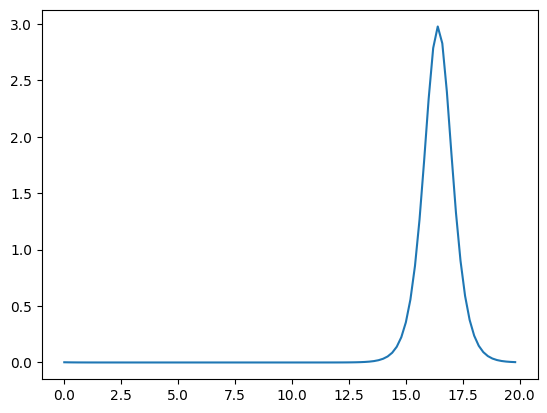

In [48]:
plt.plot(x, u_analytical(x, 4, random.key(0), P))